# Imports

In [1]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

# Testset Modification (Addition of anomalies)

In [2]:
df = pd.read_csv("data/mnist_test.csv")
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Arbitrarily choose first 1000 for corruption

anom = df[:1000]
clean = df[1000:]

In [4]:
# Function for displaying the MNIST image

def show_mnist_image(data):
    # The first column is the label
    label = data[0]
    
    # The rest of columns are pixels
    pixels = data[1:]
    
    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(pixels, dtype='int64')
    #print(pixels.shape)
    
    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((28, 28))
    #print(pixels.shape)
    
    # Plot
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap='gray')
    plt.show();

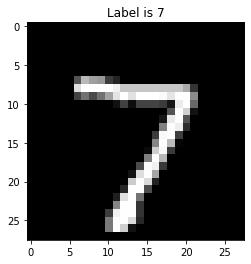

In [5]:
show_mnist_image(df.iloc[0])

In [6]:
# Apply corruption

for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [7]:
# Change the label (1 for anomaly, 0 for clean)

anom.loc[:, 'label'] = 1
clean.loc[:, 'label'] = 0

C:\Users\johnw\AppData\Local\Temp\ipykernel_24120\1565456563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom.loc[:, 'label'] = 1
C:\Users\johnw\AppData\Local\Temp\ipykernel_24120\1565456563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean.loc[:, 'label'] = 0


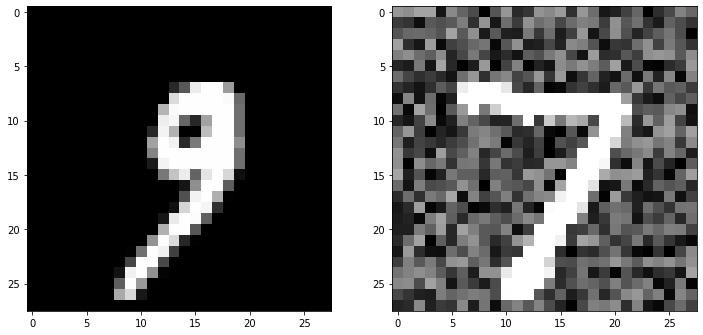

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.array(clean.iloc[0, 1:]).reshape(28, 28), cmap='gray')
axs[1].imshow(np.array(anom.iloc[0, 1:]).reshape(28, 28), cmap='gray')

plt.show();

In [9]:
# Recombine the test sets

an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('data/mnist_test_anom.csv')          # save

# Preparation of Train/Test Set

In [10]:
training_data = pd.read_csv('data/mnist_train.csv', index_col=False)

In [11]:
training_data.drop(columns=["label"], inplace=True)
an_test.drop(columns=["label"], inplace=True)

In [12]:
training_data_np = training_data.to_numpy()/255
X_train = torch.tensor(training_data_np, dtype=torch.float32)   # torch.Tensor ==> Torch Float Tensor
# y_train = torch.Tensor(training_data_np/255)

In [13]:
an_test_np = an_test.to_numpy()/255
X_test = torch.Tensor(an_test_np)
# y_test = torch.Tensor(an_test_np/255)

In [14]:
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# Autoencoder

In [15]:
# Autoencoder Class

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
        
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [16]:
# Training Parameters

BATCH_SIZE = 32
lr = 1e-2   # learning rate
w_d = 1e-5  # weight decay
momentum = 0.9
epochs = 15

In [17]:
trainloader = DataLoader(
    X_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=20,
    pin_memory=True,
    drop_last=True
)

testloader = DataLoader(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=20,
    pin_memory=True,
    drop_last=True
)

In [18]:
metrics = defaultdict(list)
model = AE()
device = 'cpu'
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [19]:
summary(model, (1, 784), device="cpu");   # Must use device='cpu'

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 16]               --
|    └─Linear: 2-1                       [-1, 1, 512]              401,920
|    └─ReLU: 2-2                         [-1, 1, 512]              --
|    └─Linear: 2-3                       [-1, 1, 256]              131,328
|    └─ReLU: 2-4                         [-1, 1, 256]              --
|    └─Linear: 2-5                       [-1, 1, 128]              32,896
|    └─ReLU: 2-6                         [-1, 1, 128]              --
|    └─Linear: 2-7                       [-1, 1, 64]               8,256
|    └─ReLU: 2-8                         [-1, 1, 64]               --
|    └─Linear: 2-9                       [-1, 1, 32]               2,080
|    └─ReLU: 2-10                        [-1, 1, 32]               --
|    └─Linear: 2-11                      [-1, 1, 16]               528
|    └─ReLU: 2-12                        [-1, 1, 16]            

In [20]:
# # To move the weights which were saved in gpu to cpu (codes from pytorch tutorial)

# PATH = "model.pt"
# torch.save(model.state_dict(), PATH)

# device = torch.device('cpu')
# model = AE()
# model.load_state_dict(torch.load(PATH, map_location=device))

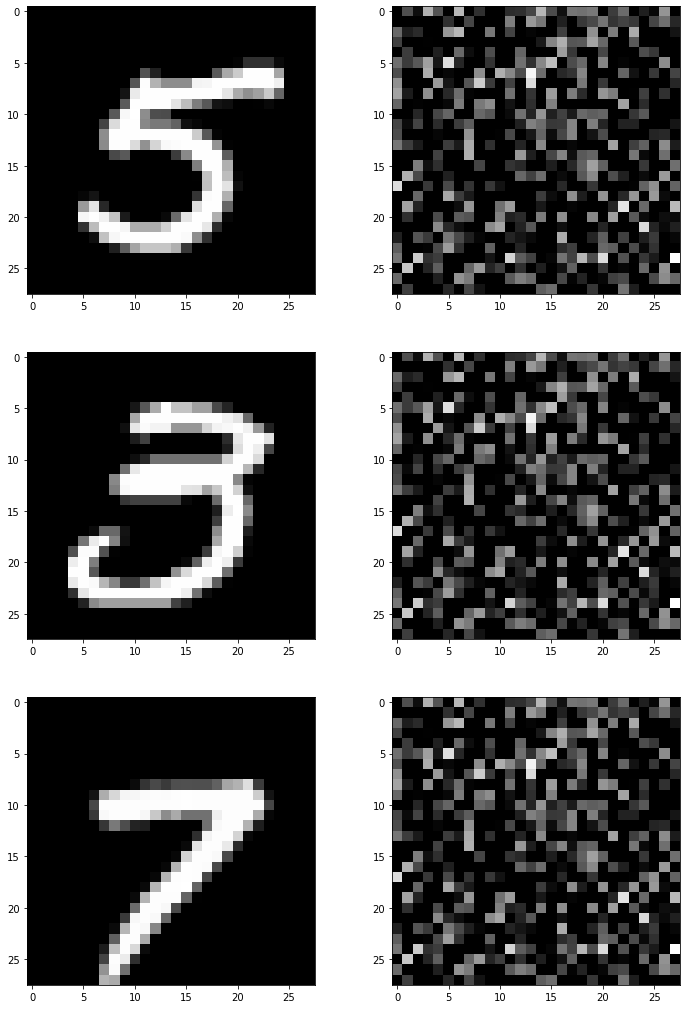

In [21]:
# Autoencoder outputs (Train Set) - Before Training

model.eval()
with torch.no_grad():
    X = next(iter(trainloader))
    y_pred = model(X)

    _, axs = plt.subplots(3, 2, figsize=(12, 18))
    axs[0, 0].imshow(np.array(X[0]).reshape(28, 28), cmap='gray')
    axs[0, 1].imshow(np.array(y_pred[0]).reshape(28, 28), cmap='gray')
    axs[1, 0].imshow(np.array(X[1]).reshape(28, 28), cmap='gray')
    axs[1, 1].imshow(np.array(y_pred[1]).reshape(28, 28), cmap='gray')
    axs[2, 0].imshow(np.array(X[2]).reshape(28, 28), cmap='gray')
    axs[2, 1].imshow(np.array(y_pred[2]).reshape(28, 28), cmap='gray')

In [22]:
#def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
def trainer(model, criterion, optimizer, trainloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    # train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    train_loss = []

    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        # valid_batch_loss = 0
        # train_batch_acc = 0
        # valid_batch_acc = 0
        
        # Training
        for X in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            loss = criterion(y_hat, X)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            # train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        # train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # model.train()
        
        # Print progress
        if verbose:
            # if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.7f}.")
                      # f"Valid Loss: {valid_loss[-1]:.3f}.",
                      # f"Train Accuracy: {train_accuracy[-1]:.2f}."
                      # f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
                
        # # Early stopping
        # if epoch > 0 and train_loss[-1] > train_loss[-2]:   # should ussing train_loss for autoencoder
        #     consec_increases += 1
        # else:
        #     consec_increases = 0
        # # if epoch > 100 and consec_increases == patience:  # Newly added condition for epoch > 100
        #     print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
        #     break
            
    print("\nTraining ended.")
    
    loss_fig = pd.DataFrame({"train_loss": train_loss}).plot.line()
    loss_fig.set_xlabel('Epoch')
    loss_fig.set_ylabel('Loss');
    
    # accur_fig = pd.DataFrame({"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}).plot.line()
    # accur_fig.set_xlabel('Epoch')
    # accur_fig.set_ylabel('Accuracy');

Epoch 1: Train Loss: 0.1071717.
Epoch 2: Train Loss: 0.1035117.
Epoch 3: Train Loss: 0.0996474.
Epoch 4: Train Loss: 0.0954946.
Epoch 5: Train Loss: 0.0912896.
Epoch 6: Train Loss: 0.0876810.
Epoch 7: Train Loss: 0.0854023.
Epoch 8: Train Loss: 0.0843727.
Epoch 9: Train Loss: 0.0839759.
Epoch 10: Train Loss: 0.0837721.
Epoch 11: Train Loss: 0.0836806.
Epoch 12: Train Loss: 0.0836424.
Epoch 13: Train Loss: 0.0836264.
Epoch 14: Train Loss: 0.0836195.
Epoch 15: Train Loss: 0.0836166.

Training ended.


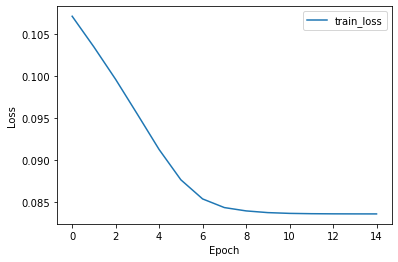

In [23]:
trainer(model, criterion, optimizer, trainloader, epochs=15, patience=5, verbose=True)

In [24]:
#torch.save(model.state_dict(), "model_autoencoder.pt")
#model = AE()
#model.load_state_dict(torch.load("model_autoencoder.pt", map_location=device))

# Prediction

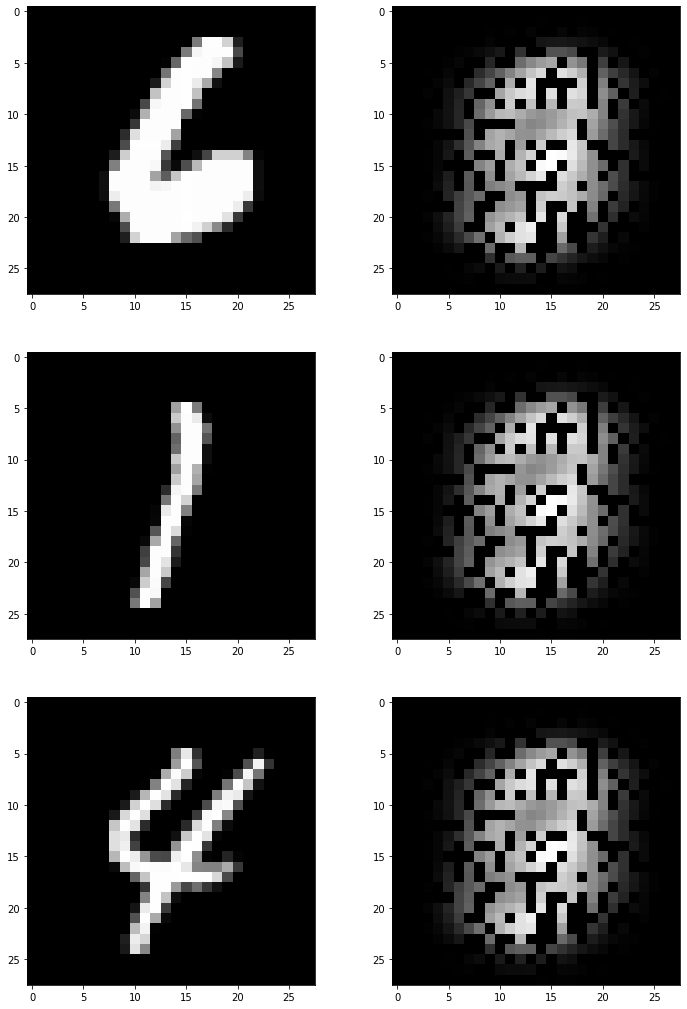

In [25]:
# Autoencoder outputs (Train Set)

model.eval()
with torch.no_grad():
    X = next(iter(trainloader))
    y_pred = model(X)

    _, axs = plt.subplots(3, 2, figsize=(12, 18))
    axs[0, 0].imshow(np.array(X[0]).reshape(28, 28), cmap='gray')
    axs[0, 1].imshow(np.array(y_pred[0]).reshape(28, 28), cmap='gray')
    axs[1, 0].imshow(np.array(X[1]).reshape(28, 28), cmap='gray')
    axs[1, 1].imshow(np.array(y_pred[1]).reshape(28, 28), cmap='gray')
    axs[2, 0].imshow(np.array(X[2]).reshape(28, 28), cmap='gray')
    axs[2, 1].imshow(np.array(y_pred[2]).reshape(28, 28), cmap='gray')

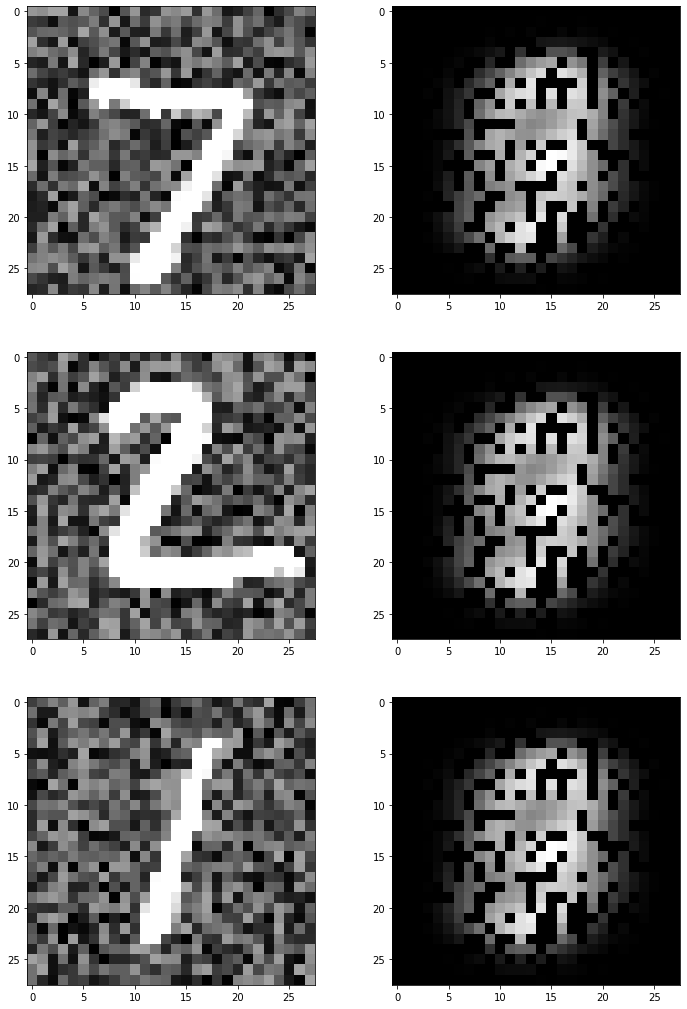

In [26]:
# Autoencoder outputs (Test Set)

model.eval()
with torch.no_grad():
    X = next(iter(testloader))
    y_pred = model(X)

    _, axs = plt.subplots(3, 2, figsize=(12, 18))
    axs[0, 0].imshow(np.array(X[0]).reshape(28, 28), cmap='gray')
    axs[0, 1].imshow(np.array(y_pred[0]).reshape(28, 28), cmap='gray')
    axs[1, 0].imshow(np.array(X[1]).reshape(28, 28), cmap='gray')
    axs[1, 1].imshow(np.array(y_pred[1]).reshape(28, 28), cmap='gray')
    axs[2, 0].imshow(np.array(X[2]).reshape(28, 28), cmap='gray')
    axs[2, 1].imshow(np.array(y_pred[2]).reshape(28, 28), cmap='gray')

In [27]:
model.eval()
loss_dist = []
anom = pd.read_csv('data/mnist_test_anom.csv', index_col=[0])

for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

# Result Analysis

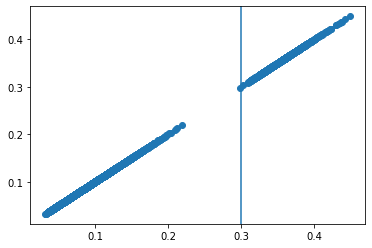

In [28]:
# Loss Comparison

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


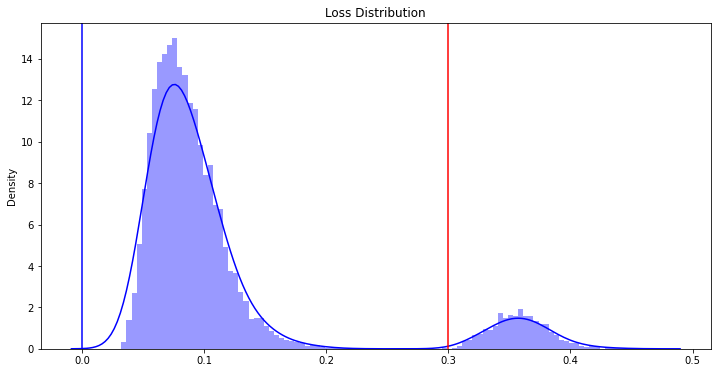

In [29]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

# Matching anomalies and loss values

In [30]:
df = pd.read_csv('data/mnist_test_anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 999	[FP] 0	[MISSED] 1
[TN] 9000	[FN] 1


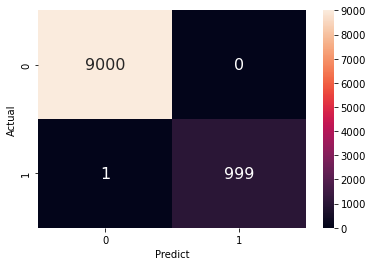

In [31]:
# Confusion Matrix

conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()